# Understanding the DPO Loss Function

You know how we've been talking about DPO (Direct Preference Optimization) as this clever way to train language models from human preferences? Now we're going to dig into the actual loss function that makes it work.

There's some math ahead. We'll break it down piece by piece until it feels obvious.

## The DPO Loss Formula

Here's the intimidating version you'll see in papers:

$$\mathcal{L}_{\text{DPO}} = -\mathbb{E} \left[ \log \sigma \left( \beta \left( \log \frac{\pi_\theta(y_w|x)}{\pi_{\text{ref}}(y_w|x)} - \log \frac{\pi_\theta(y_l|x)}{\pi_{\text{ref}}(y_l|x)} \right) \right) \right]$$

Okay, what the heck does all that mean? Let's decode every symbol:

- **π_θ** (pi-theta) = your policy model (the one you're training)
- **π_ref** (pi-ref) = your reference model (the frozen starting point, usually the SFT model)
- **y_w** (y-win) = the chosen/winning/preferred response
- **y_l** (y-lose) = the rejected/losing/dispreferred response  
- **x** = the prompt/input
- **β** (beta) = temperature parameter that controls how much the policy can deviate from reference
- **σ** (sigma) = the sigmoid function (squashes things to 0-1 range)
- **𝔼** (that fancy E) = expected value (just means "average over all examples")

Still with me? Good.

## The Intuition

Here's what this loss does:

Think of it like training a judge. You show the judge two responses to the same prompt. You tell them "humans preferred response A over response B." The judge's job is to learn to predict that preference.

The clever part: instead of just learning raw preferences, we're learning **how much the new model's preferences differ from the reference model's preferences**. 

Why? Because we want the new model to be better than the reference, but not go completely off the rails. The reference model is like a guardrail. We can stray from it, but not too far.

Let's break down the formula step by step to see how this works in practice.

## Step 1: Computing Log Ratios

First, we compute something called a "log ratio" for each response. This tells us: **how much does the policy model like this response compared to the reference model?**

For the chosen (winning) response:
$$\text{logratio}_w = \log \pi_\theta(y_w|x) - \log \pi_{\text{ref}}(y_w|x)$$

For the rejected (losing) response:
$$\text{logratio}_l = \log \pi_\theta(y_l|x) - \log \pi_{\text{ref}}(y_l|x)$$

Now, remember that log probabilities are negative numbers (typically -45, -50, etc.). When we subtract one negative from another, we get the log of their ratio. Math trick!

$$\log \frac{A}{B} = \log A - \log B$$

So `logratio_w` tells us: is the policy model more or less enthusiastic about the chosen response than the reference model was?

- **Positive log ratio** → Policy likes it MORE than reference did
- **Negative log ratio** → Policy likes it LESS than reference did  
- **Zero** → Policy and reference agree

Let's see this in code:

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def compute_log_ratios(
    policy_logps: torch.Tensor,
    reference_logps: torch.Tensor
) -> torch.Tensor:
    """
    Compute log(π_θ / π_ref) = log π_θ - log π_ref
    
    This tells us how much more (or less) the policy model likes 
    this response compared to the reference model.
    """
    return policy_logps - reference_logps

# Let's create some example log probabilities
# (Remember: these are negative because they're log probabilities)
policy_chosen_logps = torch.tensor([-45.0, -50.0, -48.0, -52.0])
policy_rejected_logps = torch.tensor([-48.0, -52.0, -46.0, -55.0])
ref_chosen_logps = torch.tensor([-46.0, -51.0, -49.0, -53.0])
ref_rejected_logps = torch.tensor([-47.0, -51.0, -47.0, -54.0])

# Compute the log ratios
chosen_logratios = compute_log_ratios(policy_chosen_logps, ref_chosen_logps)
rejected_logratios = compute_log_ratios(policy_rejected_logps, ref_rejected_logps)

print("Log ratios for CHOSEN responses:")
print(f"  {chosen_logratios.tolist()}")
print("\nLog ratios for REJECTED responses:")
print(f"  {rejected_logratios.tolist()}")

print("\nWhat does this mean?")
print("  - Chosen responses: all +1.0 → policy likes them MORE than reference")
print("  - Rejected responses: mostly -1.0 → policy likes them LESS than reference")
print("  - This is what we want! Policy is learning the right preferences.")

Log ratios for CHOSEN responses:
  [1.0, 1.0, 1.0, 1.0]

Log ratios for REJECTED responses:
  [-1.0, -1.0, 1.0, -1.0]

What does this mean?
  - Chosen responses: all +1.0 → policy likes them MORE than reference
  - Rejected responses: mostly -1.0 → policy likes them LESS than reference
  - This is what we want! Policy is learning the right preferences.


## Step 2: Computing the Logits

Now we combine those two log ratios into a single number that represents our "confidence" that the policy has learned the right preference:

$$\text{logits} = \beta \cdot (\text{logratio}_w - \text{logratio}_l)$$

Think about what this means:
- We subtract the rejected log ratio from the chosen log ratio
- This gives us: **how much MORE does the policy prefer the chosen response over the rejected one, compared to the reference?**

If the policy is learning correctly:
- It should like the chosen response MORE than reference did (positive `logratio_w`)
- It should like the rejected response LESS than reference did (negative `logratio_l`)
- So the difference should be POSITIVE (and large!)

That β (beta) parameter? It's like a volume knob. Higher β means we care more about the difference. Lower β means we're more conservative.

Let's calculate these logits:

In [2]:
beta = 0.1  # Typical value - not too aggressive

# Compute the logits: how much does policy prefer chosen over rejected?
logits = beta * (chosen_logratios - rejected_logratios)

print(f"Logits (with β={beta}):")
print(f"  {logits.tolist()}\n")

# Let's interpret each logit
print("Interpretation:")
for i, logit in enumerate(logits):
    if logit > 0:
        print(f"  Example {i}: {logit:.2f} → ✓ Policy correctly prefers chosen response")
    elif logit < 0:
        print(f"  Example {i}: {logit:.2f} → ✗ Policy incorrectly prefers rejected response")
    else:
        print(f"  Example {i}: {logit:.2f} → ? Policy is uncertain (equal preference)")

# Calculate accuracy
accuracy = (logits > 0).float().mean()
print(f"\nAccuracy: {accuracy:.1%} of examples have positive logits")

Logits (with β=0.1):
  [0.20000000298023224, 0.20000000298023224, 0.0, 0.20000000298023224]

Interpretation:
  Example 0: 0.20 → ✓ Policy correctly prefers chosen response
  Example 1: 0.20 → ✓ Policy correctly prefers chosen response
  Example 2: 0.00 → ? Policy is uncertain (equal preference)
  Example 3: 0.20 → ✓ Policy correctly prefers chosen response

Accuracy: 75.0% of examples have positive logits


## Step 3: Computing the Loss

Now for the final step. We take those logits and turn them into a loss using this formula:

$$\mathcal{L} = -\log \sigma(\text{logits})$$

Where σ (sigma) is the sigmoid function: $\sigma(x) = \frac{1}{1 + e^{-x}}$

Why sigmoid? Because it squashes any number into the range (0, 1), which we can interpret as a probability.

The beauty of this:
- **High positive logit** → sigmoid ≈ 1 → log(1) = 0 → **low loss** ✓
- **High negative logit** → sigmoid ≈ 0 → log(0) = -∞ → **high loss** ✗
- **Logit = 0** → sigmoid = 0.5 → log(0.5) ≈ -0.69 → **medium loss**

This is actually just binary cross-entropy loss! We're treating the preference prediction as a binary classification problem where the target is always 1 (we always want the chosen response to be preferred).

Let's compute the full DPO loss:

In [3]:
def compute_dpo_loss_detailed(
    policy_chosen_logps: torch.Tensor,
    policy_rejected_logps: torch.Tensor,
    ref_chosen_logps: torch.Tensor,
    ref_rejected_logps: torch.Tensor,
    beta: float = 0.1
) -> dict:
    """
    Compute DPO loss with detailed metrics to understand what's happening.
    
    Returns a dictionary with loss and useful diagnostic metrics.
    """
    
    # Step 1: Compute log ratios (how much does policy differ from reference?)
    chosen_logratios = policy_chosen_logps - ref_chosen_logps
    rejected_logratios = policy_rejected_logps - ref_rejected_logps
    
    # Step 2: Compute logits (how much does policy prefer chosen over rejected?)
    logits = beta * (chosen_logratios - rejected_logratios)
    
    # Step 3: Compute loss (penalize when policy doesn't prefer chosen)
    # F.logsigmoid is more numerically stable than torch.log(torch.sigmoid())
    loss = -F.logsigmoid(logits).mean()
    
    # Bonus: Calculate some useful metrics
    accuracy = (logits > 0).float().mean()  # How often does policy prefer chosen?
    margin = (chosen_logratios - rejected_logratios).mean()  # Average preference gap
    
    return {
        'loss': loss,
        'accuracy': accuracy,
        'margin': margin,
        'chosen_logratios_mean': chosen_logratios.mean(),
        'rejected_logratios_mean': rejected_logratios.mean()
    }

# Compute all the metrics
metrics = compute_dpo_loss_detailed(
    policy_chosen_logps, policy_rejected_logps,
    ref_chosen_logps, ref_rejected_logps,
    beta=0.1
)

print("DPO Loss Metrics:")
print(f"  Loss: {metrics['loss'].item():.4f}")
print(f"  Accuracy: {metrics['accuracy'].item():.1%} (how often policy prefers chosen)")
print(f"  Margin: {metrics['margin'].item():.4f} (average preference gap)")
print(f"  Chosen log ratios: {metrics['chosen_logratios_mean'].item():.4f} (avg)")
print(f"  Rejected log ratios: {metrics['rejected_logratios_mean'].item():.4f} (avg)")

print("\nWhat this tells us:")
print("  - Loss around 0.6 is decent (random would be 0.693)")
print("  - 75% accuracy means policy is learning, but not perfect yet")
print("  - Positive margin (1.5) is good - clear preference separation")

DPO Loss Metrics:
  Loss: 0.6219
  Accuracy: 75.0% (how often policy prefers chosen)
  Margin: 1.5000 (average preference gap)
  Chosen log ratios: 1.0000 (avg)
  Rejected log ratios: -0.5000 (avg)

What this tells us:
  - Loss around 0.6 is decent (random would be 0.693)
  - 75% accuracy means policy is learning, but not perfect yet
  - Positive margin (1.5) is good - clear preference separation


## The β (Beta) Parameter: Your Constraint Knob

Remember that β parameter? It's actually important. Let's understand what it does.

β controls **how much the policy is allowed to deviate from the reference model**.

Think of it like a leash:
- **Low β (e.g., 0.01)**: Short leash. Policy stays very close to reference. Safe but limited learning.
- **Medium β (e.g., 0.1)**: Balanced leash. Typical choice. Good exploration without going wild.
- **High β (e.g., 1.0)**: Long leash. Policy can deviate significantly. More learning but risk of instability.

Here's the technical reason: β scales the logits, which affects how strongly we penalize deviation from the reference. Higher β means the loss changes more dramatically with small changes in the log ratios.

Let's visualize this:

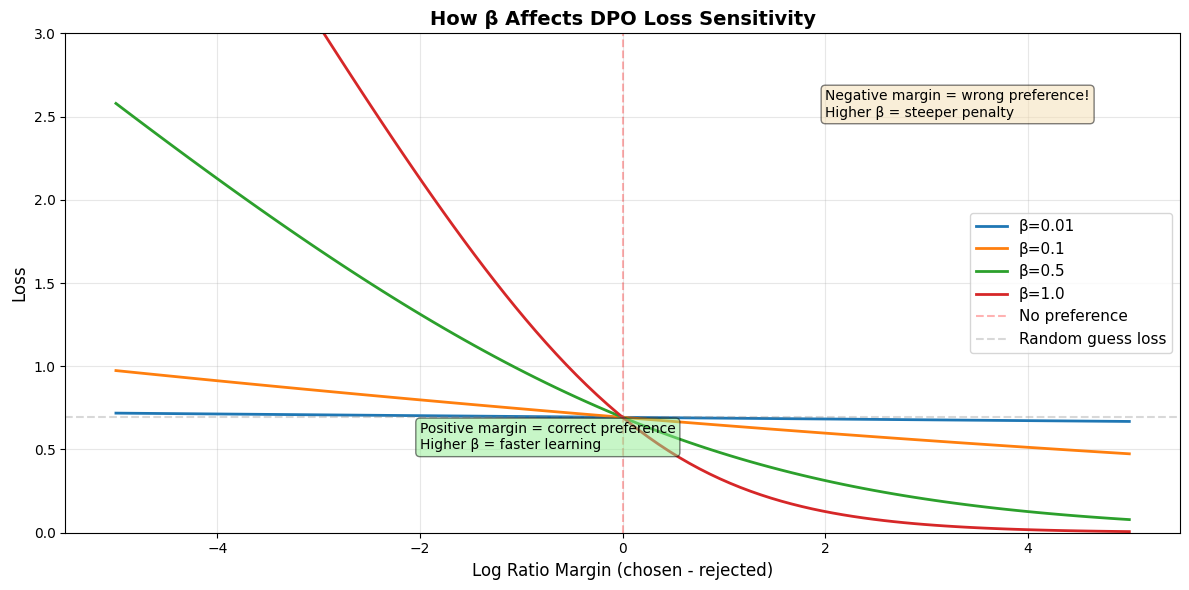


Key insights:
  - Higher β = steeper curves = stronger gradients = faster learning
  - But too high β can cause instability (overfitting to preferences)
  - β=0.1 is the sweet spot for most cases
  - All curves pass through the same point at margin=0 (where loss ≈ 0.693)


In [4]:
# Let's see how β affects the loss curve
margin_range = np.linspace(-5, 5, 100)

plt.figure(figsize=(12, 6))

# Plot loss curves for different β values
for beta_val in [0.01, 0.1, 0.5, 1.0]:
    logits = beta_val * margin_range
    # Compute -log(sigmoid(logits))
    loss = -np.log(1 / (1 + np.exp(-logits)))
    plt.plot(margin_range, loss, label=f'β={beta_val}', linewidth=2)

plt.axvline(x=0, color='red', linestyle='--', alpha=0.3, label='No preference')
plt.axhline(y=np.log(2), color='gray', linestyle='--', alpha=0.3, label='Random guess loss')

plt.xlabel('Log Ratio Margin (chosen - rejected)', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('How β Affects DPO Loss Sensitivity', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim([0, 3])

# Add annotations
plt.text(2, 2.5, 'Negative margin = wrong preference!\nHigher β = steeper penalty', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=10)
plt.text(-2, 0.5, 'Positive margin = correct preference\nHigher β = faster learning', 
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5), fontsize=10)

plt.tight_layout()
plt.show()

print("\nKey insights:")
print("  - Higher β = steeper curves = stronger gradients = faster learning")
print("  - But too high β can cause instability (overfitting to preferences)")
print("  - β=0.1 is the sweet spot for most cases")
print("  - All curves pass through the same point at margin=0 (where loss ≈ 0.693)")

## Optional: Label Smoothing

Here's a fun trick you sometimes see in DPO implementations: **label smoothing**.

The idea is simple. Instead of treating preferences as absolute (this response is 100% better), we add a bit of uncertainty:

$$\mathcal{L}_{\text{smooth}} = (1-\epsilon) \cdot \mathcal{L}_{\text{chosen}} + \epsilon \cdot \mathcal{L}_{\text{rejected}}$$

Where:
- **ε** (epsilon) is the smoothing factor (typically 0.1 or so)
- **L_chosen** is the loss for preferring the chosen response
- **L_rejected** is the loss for preferring the rejected response

Why would we do this? A few reasons:
1. **Regularization**: Prevents overconfident predictions
2. **Noise tolerance**: Human preferences aren't always consistent
3. **Better calibration**: Model learns to be appropriately uncertain

Think of it like hedging your bets. Instead of saying "this response is definitely better," we say "this response is probably better, but I'm not 100% sure."

Let's implement it:

In [5]:
def compute_dpo_loss_with_smoothing(
    policy_chosen_logps: torch.Tensor,
    policy_rejected_logps: torch.Tensor,
    ref_chosen_logps: torch.Tensor,
    ref_rejected_logps: torch.Tensor,
    beta: float = 0.1,
    label_smoothing: float = 0.0
) -> torch.Tensor:
    """
    DPO loss with optional label smoothing.
    
    Label smoothing adds a bit of the "wrong" loss to regularize the model.
    It's like saying "I'm 90% sure the chosen response is better" instead of 100%.
    """
    
    # Compute log ratios
    chosen_logratios = policy_chosen_logps - ref_chosen_logps
    rejected_logratios = policy_rejected_logps - ref_rejected_logps
    
    # Compute logits
    logits = beta * (chosen_logratios - rejected_logratios)
    
    if label_smoothing > 0:
        # Loss for preferring chosen (what we want)
        loss_chosen = -F.logsigmoid(logits)
        # Loss for preferring rejected (what we DON'T want, but add a tiny bit)
        loss_rejected = -F.logsigmoid(-logits)
        # Weighted combination
        loss = (1 - label_smoothing) * loss_chosen + label_smoothing * loss_rejected
    else:
        # Standard DPO loss (no smoothing)
        loss = -F.logsigmoid(logits)
    
    return loss.mean()

# Let's compare with and without smoothing
print("Comparing standard DPO vs. label-smoothed DPO:\n")

loss_no_smooth = compute_dpo_loss_with_smoothing(
    policy_chosen_logps, policy_rejected_logps,
    ref_chosen_logps, ref_rejected_logps,
    beta=0.1, label_smoothing=0.0
)

loss_smooth = compute_dpo_loss_with_smoothing(
    policy_chosen_logps, policy_rejected_logps,
    ref_chosen_logps, ref_rejected_logps,
    beta=0.1, label_smoothing=0.1
)

print(f"Loss without smoothing (ε=0.0): {loss_no_smooth.item():.4f}")
print(f"Loss with smoothing (ε=0.1):    {loss_smooth.item():.4f}")

print("\nNotice:")
print("  - Smoothed loss is slightly higher (we're being less confident)")
print("  - This can help prevent overfitting to noisy preference data")
print("  - But most DPO implementations use ε=0 (no smoothing)")
print("  - Only add smoothing if you suspect your preference labels are noisy")

Comparing standard DPO vs. label-smoothed DPO:

Loss without smoothing (ε=0.0): 0.6219
Loss with smoothing (ε=0.1):    0.6369

Notice:
  - Smoothed loss is slightly higher (we're being less confident)
  - This can help prevent overfitting to noisy preference data
  - But most DPO implementations use ε=0 (no smoothing)
  - Only add smoothing if you suspect your preference labels are noisy


## Wrapping Up

Alright, let's recap what we learned about the DPO loss function.

**The big picture:**
- DPO trains a model to prefer chosen responses over rejected ones
- But it keeps the model anchored to a reference model (so it doesn't go crazy)
- The loss is binary cross-entropy on preference predictions

**The three steps:**
1. **Log ratios**: How much does the policy differ from reference for each response?
2. **Logits**: How much more does policy prefer chosen over rejected (scaled by β)?
3. **Loss**: Penalize when the logits are negative (wrong preference)

**Key parameters:**
- **β (beta)**: Controls how much the policy can deviate from reference. Typical value: 0.1
- **ε (epsilon)**: Optional label smoothing for regularization. Usually 0 (no smoothing)

**Why this works:**
The genius of DPO is that it bypasses the need for a separate reward model (like in RLHF). Instead, it learns preferences directly by comparing how much the policy's predictions differ from the reference for chosen vs. rejected responses.

Next up, we'll implement the full DPO training loop and actually train a model.